Original notebook is located [here](https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/IFS/STARTHERE_IFS.ipynb)

In [1]:
# uncomment below if you see a gribscan module not found error
#%pip install gribscan

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

In [4]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

## Extra-quick version: Get interpolated & averaged IFS-FESOM (TCo2559-NG5) Cycle 3 data and create quick plots

In [5]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [6]:
print(list(cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.atmos.gr025']))

['daily']


In [7]:
%%time
ds = cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.atmos.gr025']['daily'].to_dask()

CPU times: user 31.2 s, sys: 12.8 s, total: 43.9 s
Wall time: 4min 18s


In [8]:
ds

<xarray.Dataset>
Dimensions:  (time: 730, lon: 1440, lat: 721, height: 1, plev: 19)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-02 1950-01-03 ... 1952-01-01
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * height   (height) float64 2.0
  * plev     (plev) float64 100.0 500.0 1e+03 2e+03 ... 8.5e+04 9.25e+04 1e+05
Data variables: (12/22)
    2t       (time, height, lat, lon) float32 dask.array<chunksize=(31, 1, 721, 1440), meta=np.ndarray>
    ewss     (time, lat, lon) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    msl      (time, lat, lon) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    nsss     (time, lat, lon) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    q        (time, plev, lat, lon) float32 dask.array<chunksize=(31, 1, 721, 1440), meta=np.ndarray>
    r        (time, plev, lat, lon) float32 dask.array<chunksize=(31, 1, 721, 1440), meta=np.ndarray>
    ...       ...
    tsr      (time, lat, lon) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ttr      (time, lat, lon) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    u        (time, plev, lat, lon) float32 dask.array<chunksize=(31, 1, 721, 1440), meta=np.ndarray>
    v        (time, plev, lat, lon) float32 dask.array<chunksize=(31, 1, 721, 1440), meta=np.ndarray>
    w        (time, plev, lat, lon) float32 dask.array<chunksize=(31, 1, 721, 1440), meta=np.ndarray>
    z        (time, plev, lat, lon) float32 dask.array<chunksize=(31, 1, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Nov 01 01:30:12 2023: cdo --eccodes -s -f nc4c -r selva...
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

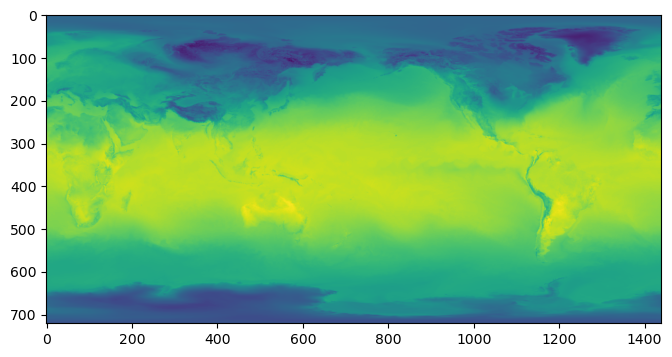

In [16]:
# reshape to (#lat x #lon) numpy array
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
sample = ds['2t'][0,0,:]
plt.imshow(sample)

An imprecise global-mean can be computed as follows. For a precise grid-area weighted mean with cdo.fldmean(), see the nextGEMS example notebook [radiation_evaluation.ipynb](https://github.com/nextGEMS/nextGEMS_Cycle3/blob/main/IFS/radiation_evaluation.ipynb)

In [17]:
ds['2t'].shape

(730, 1, 721, 1440)

Text(0.5, 1.0, 'Global-mean 2m temperature time series')

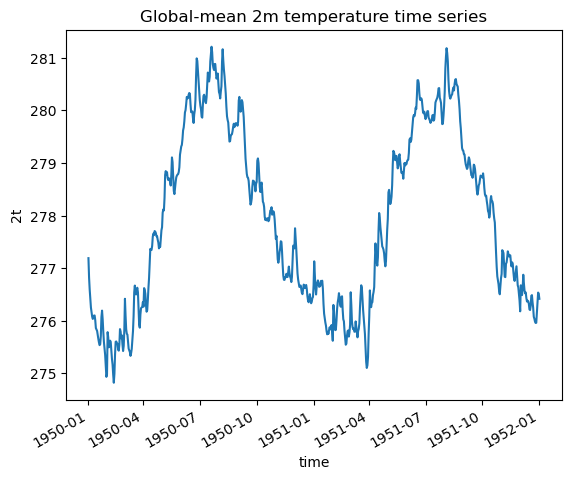

In [18]:
ds['2t'].mean(dim=['lon', 'lat', 'height']).plot() # will need area-weighting
plt.title("Global-mean 2m temperature time series")

In [22]:
ds['tp'][0,:,:].mean(dim='lat')

<xarray.DataArray 'tp' (lon: 1440)>
dask.array<mean_agg-aggregate, shape=(1440,), dtype=float32, chunksize=(1440,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1950-01-02
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

Text(0.5, 1.0, 'Zonal-mean total precipitation')

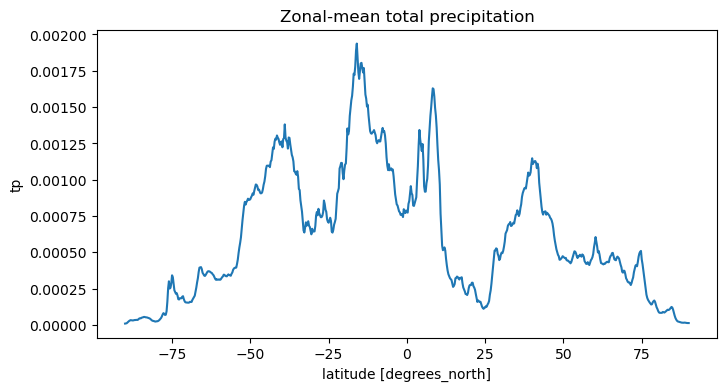

In [24]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
ds['tp'][0,:,:].mean(dim="lon").plot(ax=ax)
plt.title('Zonal-mean total precipitation')

Text(0.5, 1.0, 'Hovmoeller plot of total precipitation')

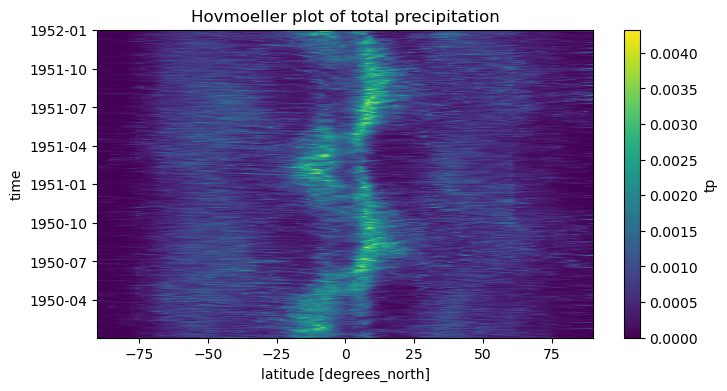

In [25]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
ds['tp'].mean(dim="lon").plot(ax=ax)
plt.title('Hovmoeller plot of total precipitation')

Save some of your favorite data to file for analysis with other tools, in this example sp (surface air pressure).

In [29]:
ds['2t'].to_netcdf('2t.nc', mode='w') # write any path + filename here

Text(0.5, 1.0, 'Global-mean SAT time series')

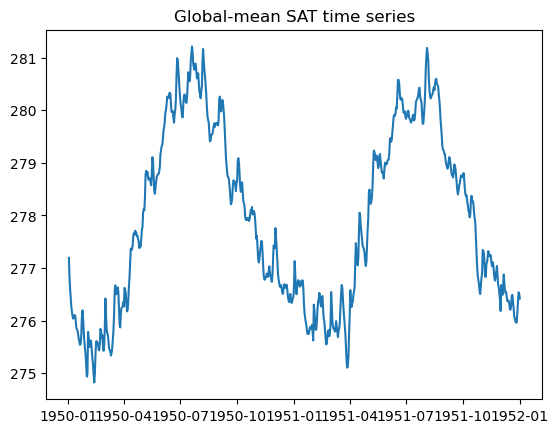

In [31]:
ncdata = xr.open_dataset('2t.nc') # read in again
plt.plot(ncdata.time, ncdata['2t'].mean(dim=("lon","lat"))) # will still need area-weighting
plt.title("Global-mean SAT time series")

## Find a point (e.g. Bremerhaven) on the map and plot timeseries

In [32]:
lon_target = 8.5809
lat_target = 53.5396

In [35]:
nearest_point = ds.sel(lon=lon_target, lat=lat_target, method="nearest", )

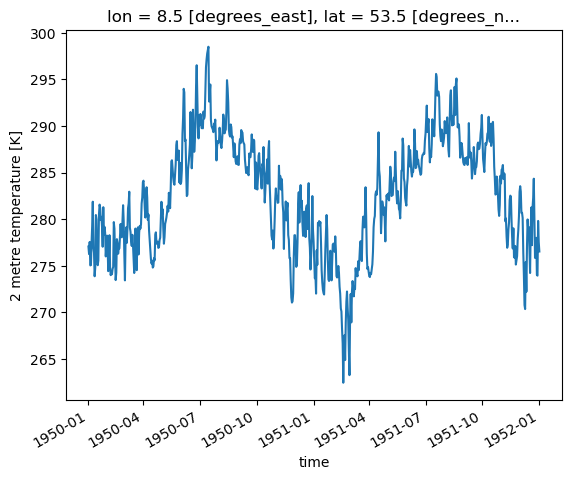

In [39]:
nearest_point['2t'][:,0].plot()

In [44]:
ds.lat

<xarray.DataArray 'lat' (lat: 721)>
array([ 90.  ,  89.75,  89.5 , ..., -89.5 , -89.75, -90.  ])
Coordinates:
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [56]:
ds.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [65]:
subset = ds.sel(lon=slice(250,320), lat=slice(60, 20)) #note reverse order of latitudes

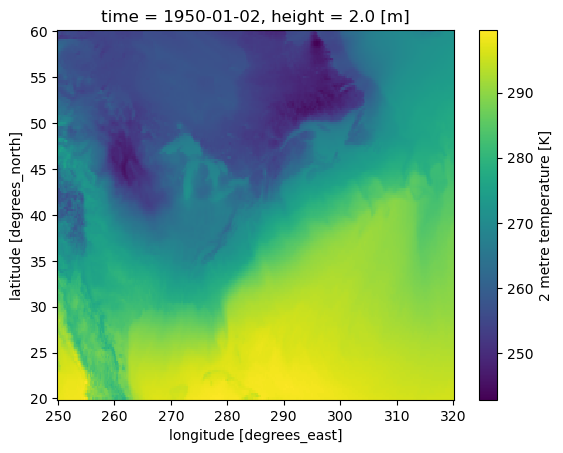

In [66]:
subset['2t'][0,0,:,:].plot()

In [68]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

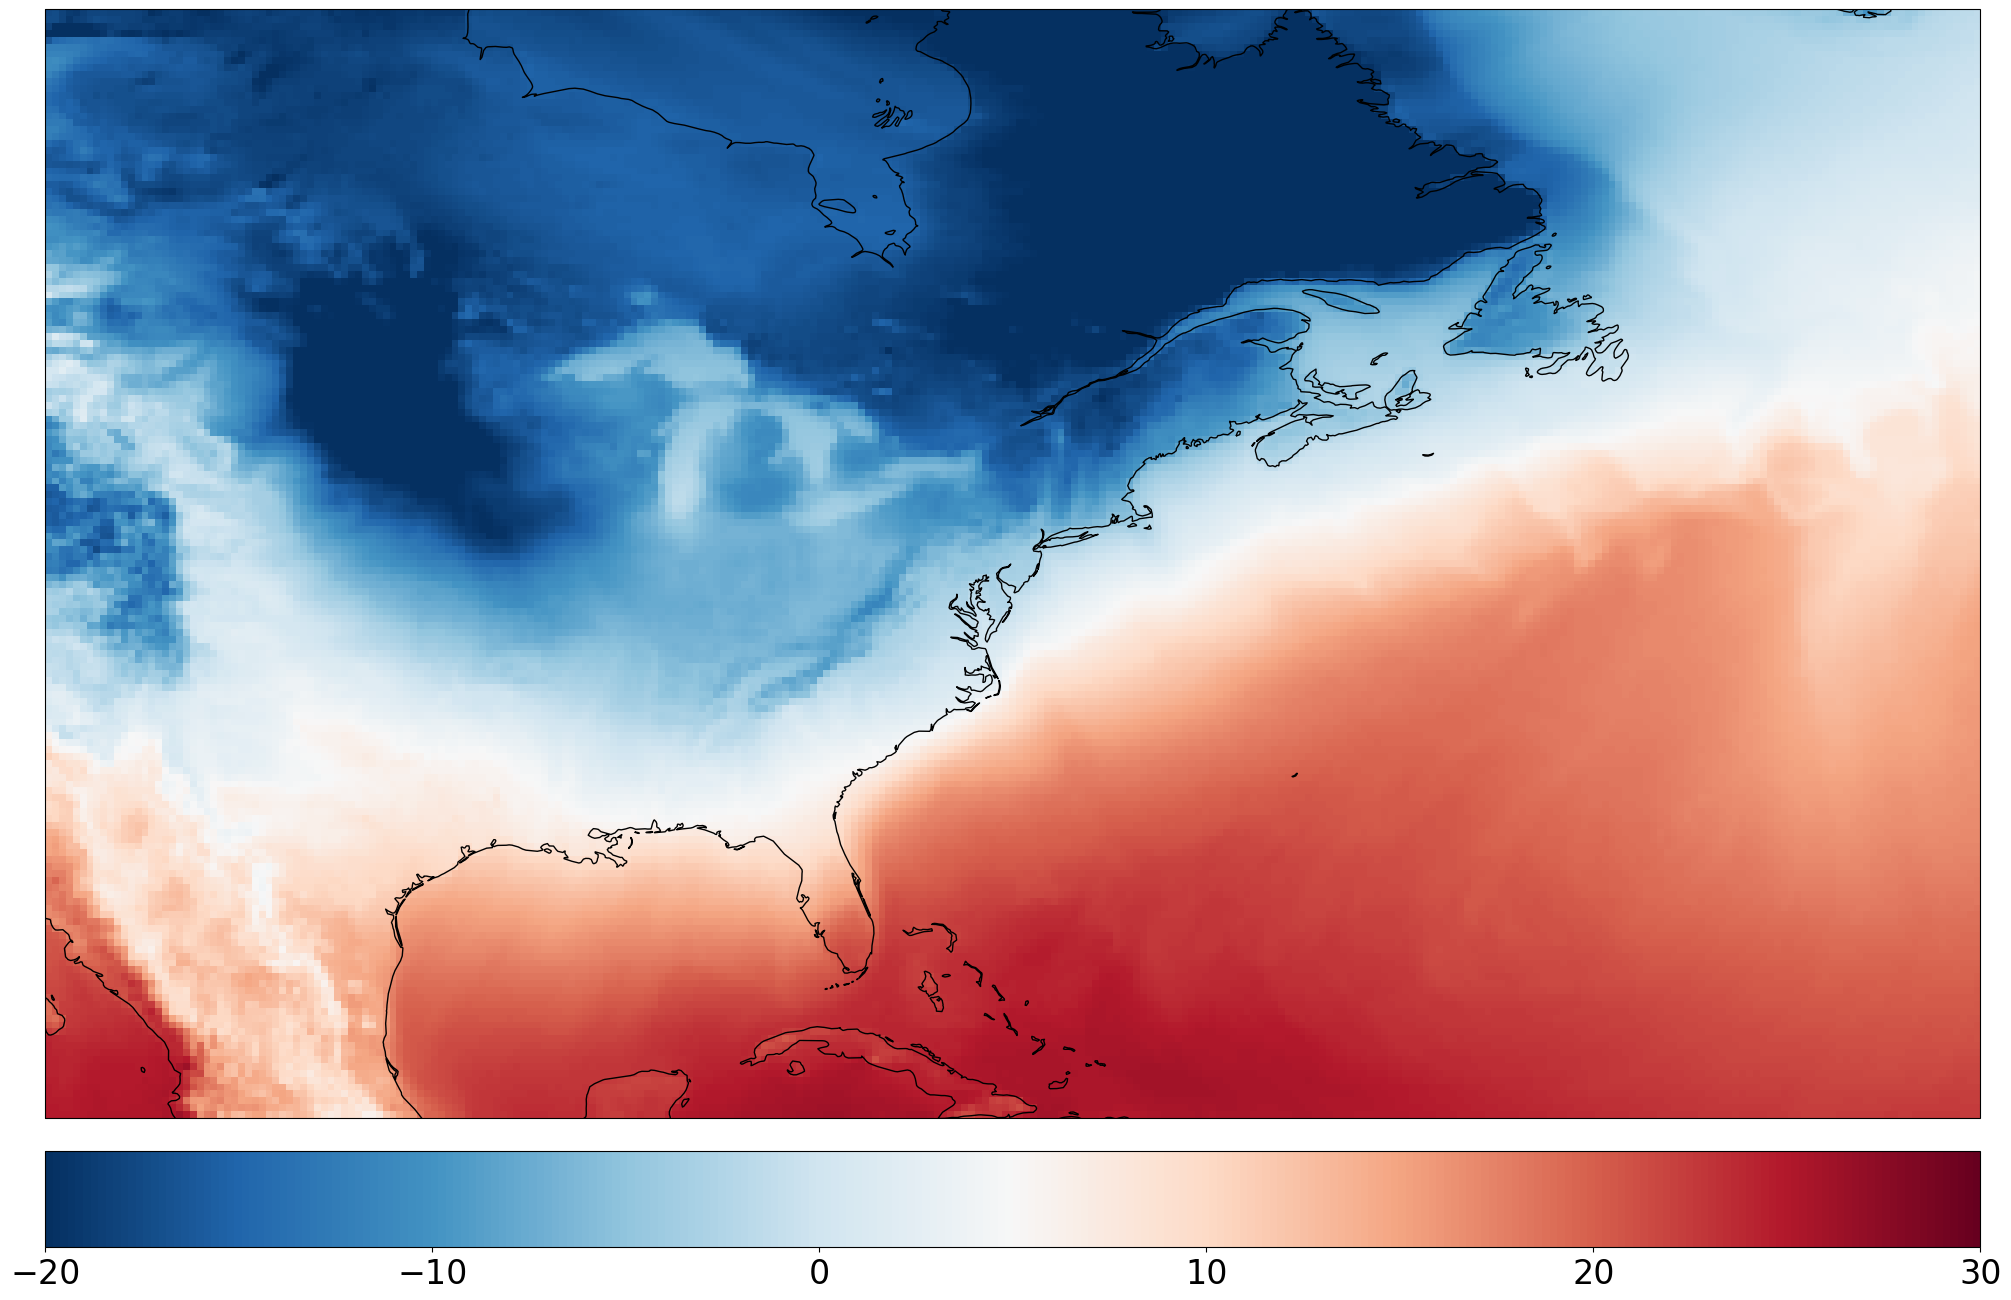

In [70]:
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.PlateCarree()),
                    constrained_layout=True,
                    figsize=(20, 30),
                )
# ax.set_extent(bbox, crs=ccrs.PlateCarree())
im1 = ax.pcolormesh(subset.lon.values, subset.lat.values, subset['2t'][0,0,:,:].values-273.15,
                    cmap=cm.RdBu_r,
                vmin=-20, vmax=30,
                # extent=(x.min(), x.max(), y.min(), y.max()),
                # interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=24)
ax.add_feature(cfeature.LAND)